In [210]:
import json
from itertools import product
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qiskit.providers.fake_provider as fp
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, execute, IBMQ
from qiskit.circuit.library import QFT
from qiskit_ionq import IonQProvider
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [2]:
eval_qubit = 3
total_qubit = eval_qubit + 1

p = 0.2
theta_p = 2 * np.arcsin(np.sqrt(p))  # QAA의 A를 만들기 위한 Ry 각도
theta_for_q = 2 * theta_p  # Q의 각도

shots = 10000

In [3]:
qreg_q = QuantumRegister(total_qubit, 'q')
creg_c = ClassicalRegister(total_qubit-1, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

In [4]:
circuit.h(qreg_q[0:eval_qubit])
circuit.ry(theta_p, qreg_q[eval_qubit])
circuit.barrier()

for i in range(eval_qubit):
    circuit.cry(theta_for_q * (2 ** i), qreg_q[i], qreg_q[eval_qubit])
    circuit.barrier()

circuit.append(QFT(eval_qubit, inverse=True, do_swaps=True),
               qreg_q[0:eval_qubit])

circuit.barrier()

circuit.measure(qreg_q[0:eval_qubit], creg_c[0:eval_qubit])
circuit.barrier()

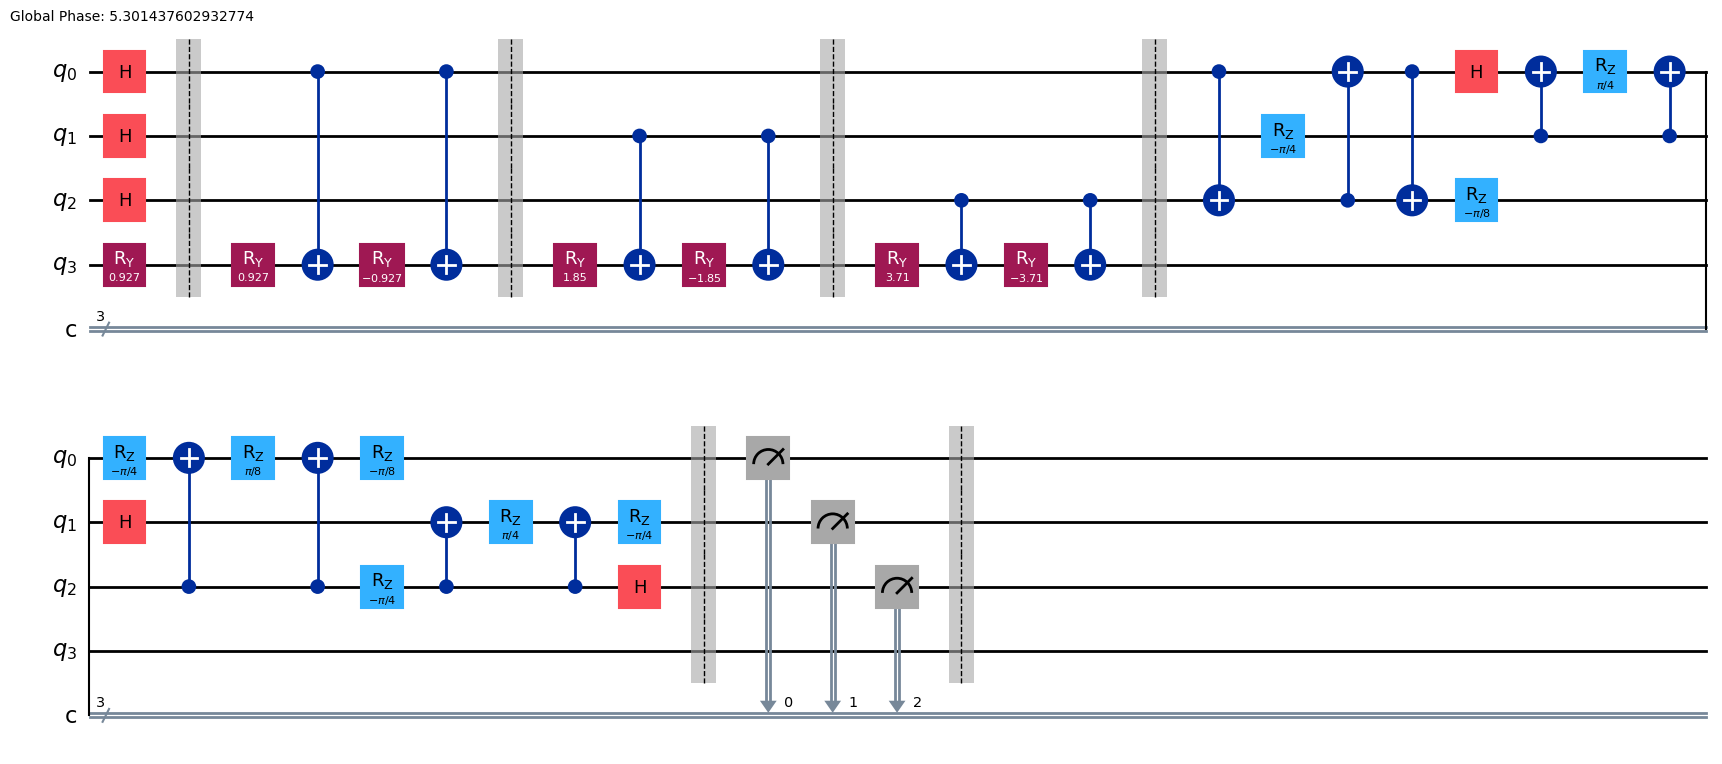

In [5]:
transpile(circuit, basis_gates=['h', 'cx', 'rx', 'rz', 'ry']).draw(output='mpl', style="iqp")

# Fig 3 a

In [6]:
fig1_raw = transpile(circuit, basis_gates=['h', 'cx', 'rx', 'rz', 'cry', 'ry'])

In [7]:
fig1_raw.__setattr__('_global_phase', 0)

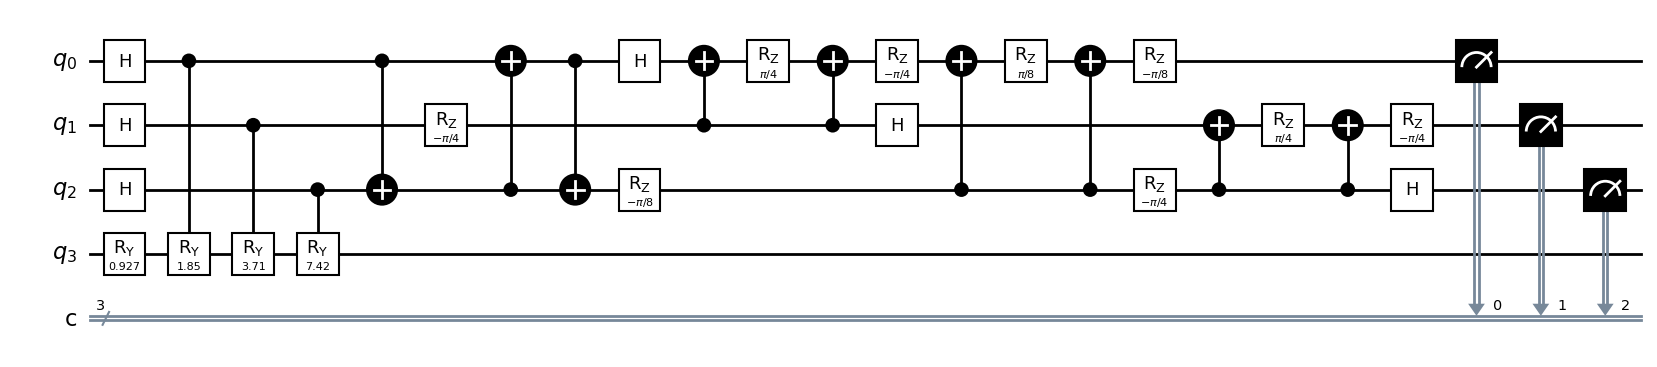

In [8]:
fig1_raw.draw(output='mpl', style="bw", fold=24, justify='left', plot_barriers=False)

In [9]:
fig1_raw.qasm(formatted=True)
# fig1_raw.qasm(formatted=True, filename='figs/ideal_raw.qasm')

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
creg c[3];
h q[0];
h q[1];
h q[2];
ry(0.9272952180016122) q[3];
barrier q[0],q[1],q[2],q[3];
cry(1.8545904360032244) q[0],q[3];
barrier q[0],q[1],q[2],q[3];
cry(3.7091808720064487) q[1],q[3];
barrier q[0],q[1],q[2],q[3];
cry(7.4183617440128975) q[2],q[3];
barrier q[0],q[1],q[2],q[3];
cx q[0],q[2];
rz(-pi/4) q[1];
cx q[2],q[0];
cx q[0],q[2];
h q[0];
cx q[1],q[0];
rz(pi/4) q[0];
cx q[1],q[0];
rz(-pi/4) q[0];
h q[1];
rz(-pi/8) q[2];
cx q[2],q[0];
rz(pi/8) q[0];
cx q[2],q[0];
rz(-pi/8) q[0];
rz(-pi/4) q[2];
cx q[2],q[1];
rz(pi/4) q[1];
cx q[2],q[1];
rz(-pi/4) q[1];
h q[2];
barrier q[0],q[1],q[2],q[3];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
barrier q[0],q[1],q[2],q[3];


In [10]:
fig1_raw_qasm = QuantumCircuit.from_qasm_file('figs/ideal_raw.qasm')

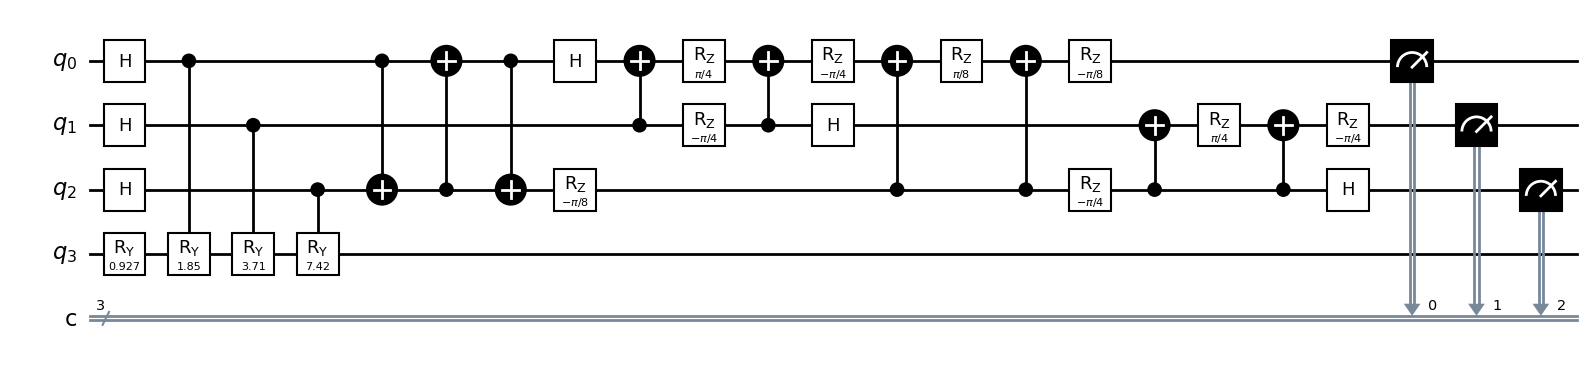

In [11]:
fig1_raw_qasm.draw(output='mpl', style="bw", fold=24, 
                   # filename='figs/ideal_raw.png', 
                   plot_barriers=False)

# Fig 3 b

In [12]:
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.h(qreg_q[0:eval_qubit])
circuit.ry(theta_p, qreg_q[eval_qubit])
circuit.barrier()

for i in range(eval_qubit):
    circuit.cry(theta_for_q * (2 ** (eval_qubit - 1 - i)), qreg_q[i], qreg_q[eval_qubit])
    circuit.barrier()

circuit.append(QFT(eval_qubit, inverse=True, do_swaps=False),
               qreg_q[0:eval_qubit])
circuit.barrier()
circuit.measure(qreg_q[0:eval_qubit], creg_c[0:eval_qubit])

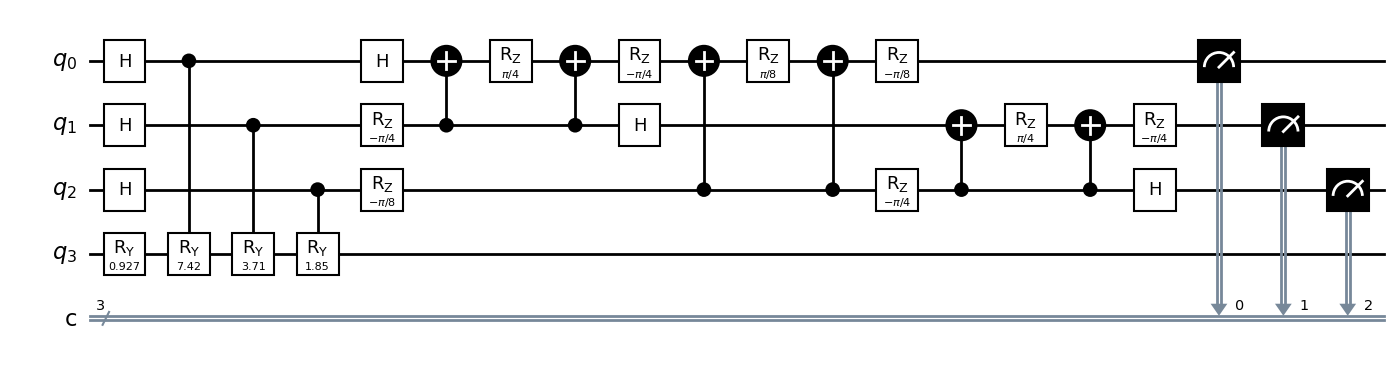

In [13]:
fig1_opt = transpile(circuit, basis_gates=['h', 'cx', 'rx', 'rz', 'ry', 'cry'])
fig1_opt.__setattr__('_global_phase', 0)
fig1_opt.draw(output='mpl', style="bw", fold=21, 
              # filename='figs/ideal_opt.png', 
              plot_barriers=False)

# Fig 4

In [14]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, simulator, shots=shots).result()
counts = result.get_counts(circuit)

In [15]:
counts  #반대 순서

{'101': 87,
 '100': 63,
 '001': 4522,
 '110': 271,
 '010': 253,
 '000': 209,
 '011': 63,
 '111': 4532}

In [16]:
counts = {key: value / shots for key, value in counts.items()}

In [17]:
p_tilde = [np.round(np.sin(i*np.pi/(2**eval_qubit))**2,3) for i in range(2**(eval_qubit-1)+1)]

In [18]:
p_tilde

[0.0, 0.146, 0.5, 0.854, 1.0]

In [19]:
probs = np.zeros(2**eval_qubit, dtype=float)
for state, value in counts.items():
    state_decimal = int(state, 2)
    probs[state_decimal] = value
    
freqs =[]
freqs.append(probs[0])
i = 1
while i < 2**eval_qubit/2:
    # print(f'These states correspond to the same bin: {i} and {2**m-i}')
    freqs.append(probs[i] + probs[2**eval_qubit-i])
    i += 1
freqs.append(probs[2**(eval_qubit-1)])

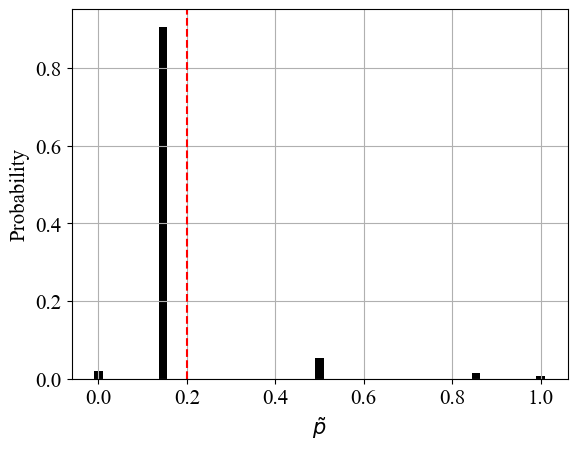

In [20]:
gridpoints = list(p_tilde)
probabilities = list(freqs)

plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 15})

plt.bar(gridpoints, probabilities, width=0.1 / len(probabilities), color='black')
plt.axvline(p, color="r", ls="--")
plt.ylabel("Probability")
plt.xlabel(r"$\tilde{p}$")
plt.grid()
# plt.savefig('figs/ideal_result.png', dpi=500)
plt.show()

# Fig 7

In [21]:
# plot_gate_map(fp.FakeYorktown(), filename='figs/FakeYorktown.png')
# plot_gate_map(fp.FakeTokyo(), filename='figs/FakeTokyo.png')
# plot_gate_map(fp.FakeCairo(), filename='figs/FakeCairo.png')

# Fig 9

In [22]:
backend = fp.FakeYorktown()

In [27]:
yorktown_circ = transpile(circuit, backend=backend)

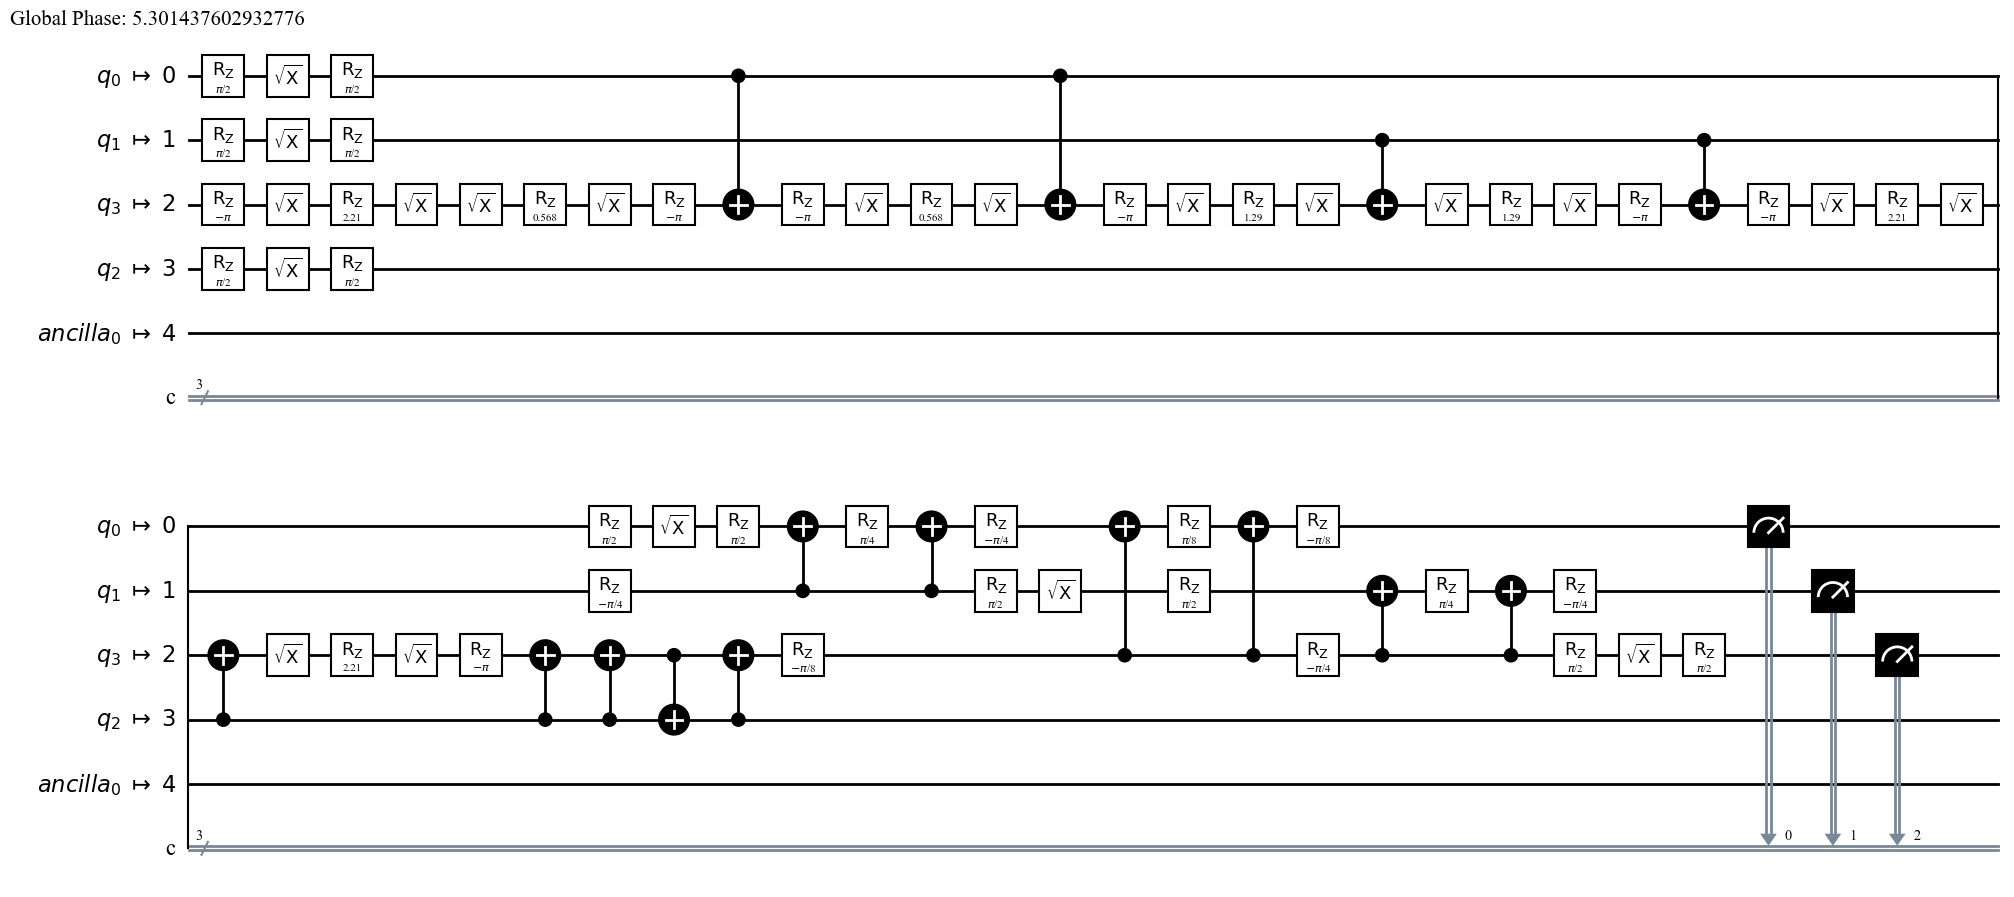

In [31]:
yorktown_circ.draw(output='mpl', style="bw", fold=28, plot_barriers=False)

In [34]:
# yorktown_circ.qasm(formatted=True, filename='figs/yorktown_circ.qasm')

In [32]:
yorktown_circ_qasm = QuantumCircuit.from_qasm_file('figs/yorktown_circ.qasm')

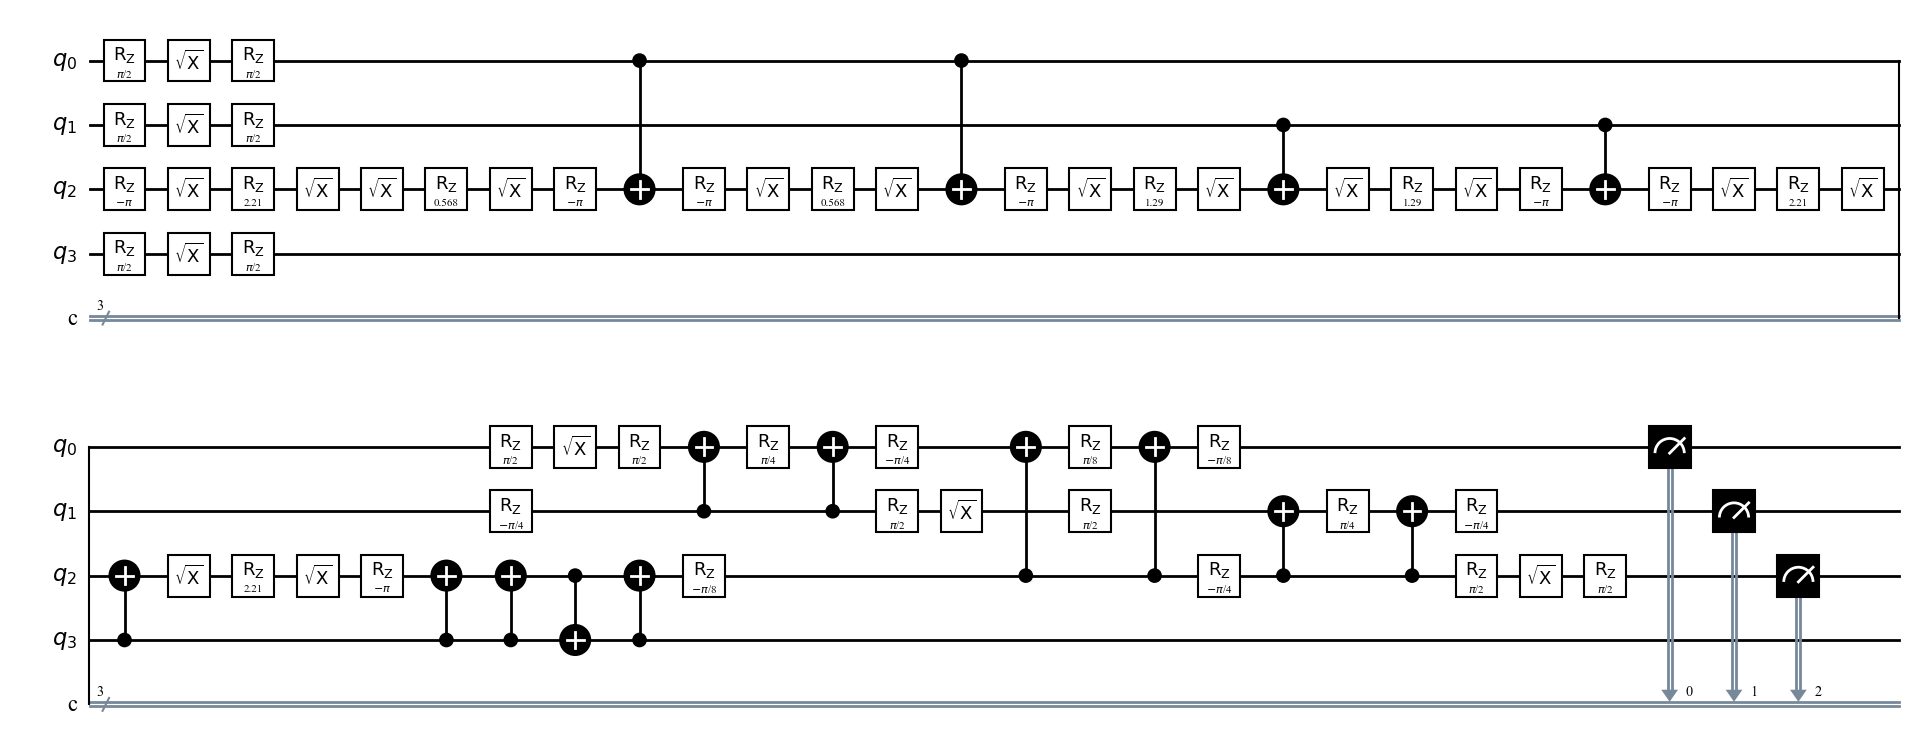

In [35]:
yorktown_circ_qasm.draw(output='mpl', style="bw", fold=28, filename='figs/york_circ.png', plot_barriers=False)

# Fig 10

In [36]:
def make_circuit(eval_qubit: int,
                 barrier: Optional[bool] = False,
                 measure: Optional[bool] = False) -> QuantumCircuit:
    eval_qubit = eval_qubit
    total_qubit = eval_qubit + 1  # eval + target qubit 1개

    p = 0.2
    theta_p = 2 * np.arcsin(np.sqrt(p))  # QAA의 A를 만들기 위한 Ry 각도
    theta_for_q = 2 * theta_p  # Q의 각도

    qreg_q = QuantumRegister(total_qubit, 'q')
    creg_c = ClassicalRegister(total_qubit - 1, 'c')  # 하나 없어도 되나?
    circuit = QuantumCircuit(qreg_q, creg_c)

    circuit.h(qreg_q[0:eval_qubit])
    circuit.ry(theta_p, qreg_q[eval_qubit])
    if barrier:
        circuit.barrier()

    for i in range(eval_qubit):
        circuit.cry(theta_for_q * (2 ** (eval_qubit - 1 - i)), qreg_q[i], qreg_q[eval_qubit])
        if barrier:
            circuit.barrier()

    circuit.append(QFT(eval_qubit, inverse=True, do_swaps=False),
                   qreg_q[0:eval_qubit])
    if barrier:
        circuit.barrier()
    if measure:
        for i in range(eval_qubit):
            circuit.measure(qreg_q[i], creg_c[i])

    return circuit

In [37]:
def transpile_circuit(circuit: QuantumCircuit, type: str) -> QuantumCircuit:
    if type == 'ionq':
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['u', 'rxx', 'id'])
    if type == 'ibm_ideal':
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'])
    if type == 'ibm_tokyo':
        backend = fp.FakeTokyo()
        if circuit.num_qubits > backend.configuration().n_qubits:
            return QuantumCircuit(1, 1)
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'],
                                       backend=backend)
    if type == 'ibm_cairo':
        backend = fp.FakeCairo()
        if circuit.num_qubits > backend.configuration().n_qubits:
            return QuantumCircuit(1, 1)
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'],
                                       backend=backend)

    return transpiled_circuit

In [51]:
circuit_setting = {"eval_qubit": list(range(1, 20))}
transpile_setting = ['ionq', 'ibm_ideal', 'ibm_tokyo', 'ibm_cairo']

In [52]:
result = pd.DataFrame(columns=['eval_qubit', 'device', 'depth', 'two_qubit'])
for combo in product(*circuit_setting.values()):
    circuit = make_circuit(*combo)
    for type in transpile_setting:
        depth_list = []
        two_qubit_list = []
        for repetition in range(2):  ## adjust here to guarantee minima
            transpiled_circuit = transpile_circuit(circuit=circuit, type=type)

            depth_candidate = transpiled_circuit.depth()
            depth_list.append(depth_candidate)

            if type == 'ionq':
                two_qubit_candidate = transpiled_circuit.count_ops()['rxx']
                two_qubit_list.append(two_qubit_candidate)
            else:
                two_qubit_candidate = transpiled_circuit.count_ops()['cx']
                two_qubit_list.append(two_qubit_candidate)
        depth = min(depth_list)
        two_qubit = min(two_qubit_list)
        result.loc[len(result)] = [*combo, type, depth, two_qubit]

In [56]:
result_pivot = result.pivot(index='eval_qubit', columns='device', values='two_qubit').reset_index()

In [130]:
def polynomial(x, a, b, c):
    return a * x ** 2 + b * x + c

/Users/jaewoongheo/anaconda3/envs/QRA/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning:

Covariance of the parameters could not be estimated

/Users/jaewoongheo/anaconda3/envs/QRA/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning:

Covariance of the parameters could not be estimated



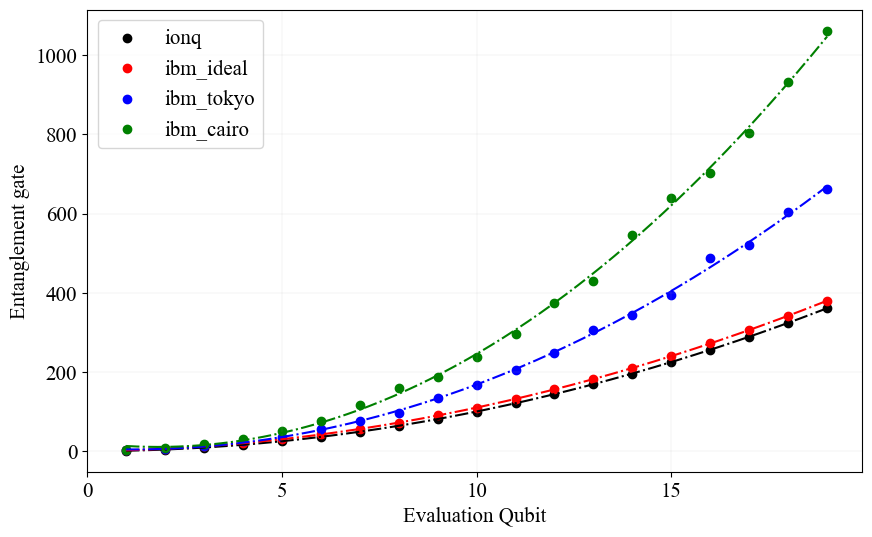

In [131]:
# Fitting과 시각화를 위한 코드
plt.figure(figsize=(10, 6))

# X 범위 정의
x_min = int(min(result_pivot['eval_qubit']))
x_max = int(max(result_pivot['eval_qubit'])) + 1 
x_range = np.linspace(min(result_pivot['eval_qubit']), max(result_pivot['eval_qubit']), 400)

# 데이터 세트 이름과 색상
datasets = {
    'ionq': 'black',
    'ibm_ideal': 'red',
    'ibm_tokyo': 'blue',
    'ibm_cairo': 'green'
}

# 각 데이터 세트에 대해 반복
for name, color in datasets.items():
    # Fitting 수행
    params, _ = curve_fit(polynomial, result_pivot['eval_qubit'], result_pivot[name])
    
    # 원본 데이터 Scatter Plot
    plt.scatter(result_pivot['eval_qubit'], result_pivot[name], label=f'{name}', color=color)
    
    # Fitted Line Plot
    plt.plot(x_range, polynomial(x_range, *params), linestyle='-.', color=color)

# 그래프 세팅
plt.xticks(np.arange(0, x_max, 5)) 
plt.grid(True, which='major', linestyle='-', linewidth=0.1)
plt.legend()
plt.xlabel('Evaluation Qubit')
plt.ylabel('Entanglement gate')

plt.savefig('figs/two_graph.png',dpi=500)

plt.show()

In [132]:
for name in datasets.keys():
    # Fitting 수행
    params, _ = curve_fit(polynomial, result_pivot['eval_qubit'], result_pivot[name])
    print(name, params)

ionq [ 1.00000000e+00 -2.18181029e-12 -2.17855634e-12]
ibm_ideal [ 1.00000000e+00  1.00000000e+00 -2.18114415e-12]
ibm_tokyo [ 2.07887365 -4.64764853  6.80185759]
ibm_cairo [  3.51407932 -12.81491965  22.26625387]


/Users/jaewoongheo/anaconda3/envs/QRA/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning:

Covariance of the parameters could not be estimated

/Users/jaewoongheo/anaconda3/envs/QRA/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning:

Covariance of the parameters could not be estimated



In [142]:
x_data = result_pivot['eval_qubit']
y_data = result_pivot['ibm_cairo'] #ionq, ibm_ideal, ibm_tokyo, ibm_cairo

params, _ = curve_fit(polynomial, x_data, y_data)

# 예측된 y값 계산
y_pred = polynomial(x_data, *params)

# R^2 값 계산
r_squared = r2_score(y_data, y_pred)
print('R^2 value:', r_squared)

R^2 value: 0.9988550986472894


# Fig 12

In [193]:
eval_qubit = 4
total_qubit = eval_qubit + 1

p = 0.2
theta_p = 2 * np.arcsin(np.sqrt(p))  # QAA의 A를 만들기 위한 Ry 각도
theta_for_q = 2 * theta_p  # Q의 각도

shots = 10000

In [194]:
qreg_q = QuantumRegister(total_qubit, 'q')
creg_c = ClassicalRegister(total_qubit-1, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

In [195]:
circuit.h(qreg_q[0:eval_qubit])
circuit.ry(theta_p, qreg_q[eval_qubit])
circuit.barrier()

for i in range(eval_qubit):
    circuit.cry(theta_for_q * (2 ** (eval_qubit - 1 - i)), qreg_q[i], qreg_q[eval_qubit])
    circuit.barrier()

circuit.append(QFT(eval_qubit, inverse=True, do_swaps=False),
               qreg_q[0:eval_qubit])
circuit.barrier()
circuit.measure(qreg_q[0:eval_qubit], creg_c[0:eval_qubit])

In [168]:
with open('qpu_keys.json', 'r') as keyfile:
    key = json.load(keyfile)['IBM']

In [173]:
IBMQ.delete_account()

In [174]:
IBMQ.active_account()

In [175]:
IBMQ.save_account(key)

In [196]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2024-03-18 11:14:29,374: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [197]:
provider = IBMQ.get_provider('ibm-q')

In [198]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_brisbane') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_kyoto') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_osaka') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [199]:
backend = provider.get_backend('ibm_kyoto')

In [200]:
job = execute(circuit, backend=backend, shots=8192)
result = job.result()

# 결과 출력
# print(result.get_counts(circuit))

In [201]:
result

Result(backend_name='ibm_kyoto', backend_version='0.0.0', qobj_id='Unknown', job_id='Unknown', success=True, results=[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'0x4': 308, '0x0': 448, '0x3': 457, '0x9': 183, '0xb': 825, '0x6': 689, '0xc': 218, '0x8': 326, '0xe': 661, '0x1': 228, '0xf': 627, '0xd': 243, '0x2': 1222, '0xa': 656, '0x5': 306, '0x7': 795}), header=QobjExperimentHeader(clbit_labels=[['c', 0], ['c', 1], ['c', 2], ['c', 3]], creg_sizes=[['c', 4]], global_phase=2.2580197197676544, memory_slots=4, metadata={}, n_qubits=127, name='circuit-24579', qreg_sizes=[['q', 127]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6], ['q', 7], ['q', 8], ['q', 9], ['q', 10], ['q', 11], ['q', 12], ['q', 13], ['q', 14], ['q', 15], ['q', 16], ['q', 17], ['q', 18], ['q', 19], ['q', 20], ['q', 21], ['q', 22], ['q', 23], ['q', 24], ['q', 25], ['q', 26], ['q', 27], ['q', 28], ['q', 29], ['q', 30], ['q', 31], ['q', 32], 

In [202]:
counts = result.get_counts(circuit)

In [203]:
counts = {key: value / shots for key, value in counts.items()}

In [204]:
p_tilde = [np.round(np.sin(i*np.pi/(2**eval_qubit))**2,3) for i in range(2**(eval_qubit-1)+1)]

In [205]:
p_tilde

[0.0, 0.038, 0.146, 0.309, 0.5, 0.691, 0.854, 0.962, 1.0]

In [206]:
probs = np.zeros(2**eval_qubit, dtype=float)
for state, value in counts.items():
    state_decimal = int(state, 2)
    probs[state_decimal] = value
    
freqs =[]
freqs.append(probs[0])
i = 1
while i < 2**eval_qubit/2:
    # print(f'These states correspond to the same bin: {i} and {2**m-i}')
    freqs.append(probs[i] + probs[2**eval_qubit-i])
    i += 1
freqs.append(probs[2**(eval_qubit-1)])

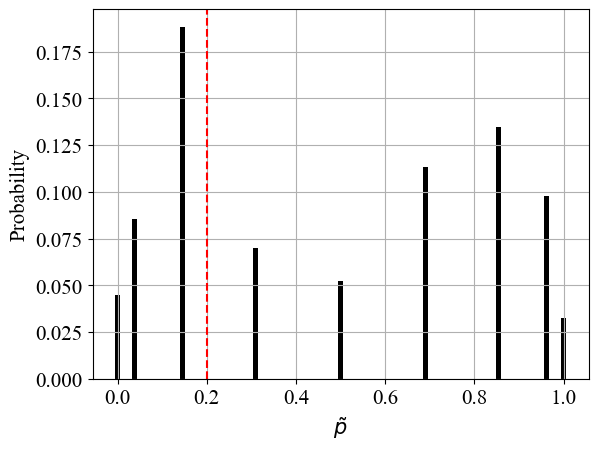

In [207]:
gridpoints = list(p_tilde)
probabilities = list(freqs)

plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 15})

plt.bar(gridpoints, probabilities, width=0.1 / len(probabilities), color='black')
plt.axvline(p, color="r", ls="--")
plt.ylabel("Probability")
plt.xlabel(r"$\tilde{p}$")
plt.grid()
# plt.savefig('figs/ideal_result.png', dpi=500)
plt.show()

In [154]:
provider = IonQProvider(key)

In [155]:
provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

In [157]:
backend = provider.get_backend('ionq_qpu')

In [158]:
circuit.draw()

┌───┐      ░                ░                ░                ░ »
q_0: ────┤ H ├──────░───────■────────░────────────────░────────────────░─»
         ├───┤      ░       │        ░                ░                ░ »
q_1: ────┤ H ├──────░───────┼────────░───────■────────░────────────────░─»
         ├───┤      ░       │        ░       │        ░                ░ »
q_2: ────┤ H ├──────░───────┼────────░───────┼────────░───────■────────░─»
     ┌───┴───┴────┐ ░ ┌─────┴──────┐ ░ ┌─────┴──────┐ ░ ┌─────┴──────┐ ░ »
q_3: ┤ Ry(0.9273) ├─░─┤ Ry(7.4184) ├─░─┤ Ry(3.7092) ├─░─┤ Ry(1.8546) ├─░─»
     └────────────┘ ░ └────────────┘ ░ └────────────┘ ░ └────────────┘ ░ »
c: 3/════════════════════════════════════════════════════════════════════»
                                                                         »
«     ┌───────┐ ░ ┌─┐      
«q_0: ┤0      ├─░─┤M├──────
«     │       │ ░ └╥┘┌─┐   
«q_1: ┤1 IQFT ├─░──╫─┤M├───
«     │       │ ░  ║ └╥┘┌─┐
«q_2: ┤2      ├─░──╫──╫─┤M├
«     └───────┘ ░  ║  ║ └╥┘
«q_3: ──────────░──╫──╫──╫─
«               ░  ║  ║  ║ 
«c: 3/═════════════╩══╩══╩═
«                  0  1  2

In [161]:
qpu_job = backend.run(transpile(circuit, basis_gates=['rx', 'ry', 'rz', 'rxx', 'id']), shots=5)

IonQAPIError: IonQAPIError(message='Unable to run jobs on IonQ QPU. Please visit our Quantum Cloud Page https://ionq.com/quantum-cloud to learn more about getting access to our QPUs',status_code=400,headers={'Date': 'Sun, 17 Mar 2024 15:44:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '198', 'Connection': 'keep-alive', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Expose-Headers': 'x-ionq-session', 'Cache-Control': 'no-cache', 'Strict-Transport-Security': "'max-age=86400; includeSubDomains'", 'Vary': 'origin, Origin', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '865e1ab50fc430d9-ICN'},body={"error":"Bad Request","statusCode":400,"message":"Unable to run jobs on IonQ QPU. Please visit our Quantum Cloud Page https://ionq.com/quantum-cloud to learn more about getting access to our QPUs"},error_type='Bad Request')